Use GPyTorch
Eclipsing binary + Pulsation + noise
Remove the eclipsing binary signal (using periodic window) and model the rest of the signal

In [1]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("../data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [6]:
def plot_data(X, Y):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Plot observations
    plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])
    
def plot_lomb_scargle_periodogram(x, y, min_freq, max_freq, frequencies=None):
    if frequencies is not None:
        power = LombScargle(x, y).power(frequencies)
    else:
        frequencies, power = LombScargle(x, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    plt.figure(figsize=(35, 5))
    plt.plot(frequencies, power)
    plt.xlabel("frequency"), plt.ylabel("power")
    return frequencies, power

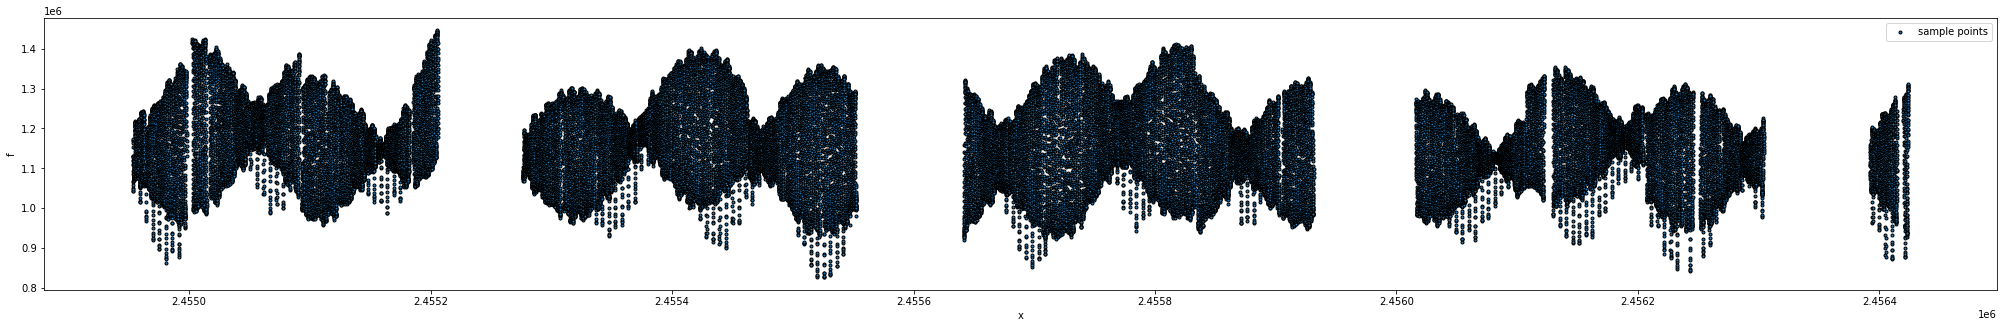

In [7]:
plot_data(X, Y)

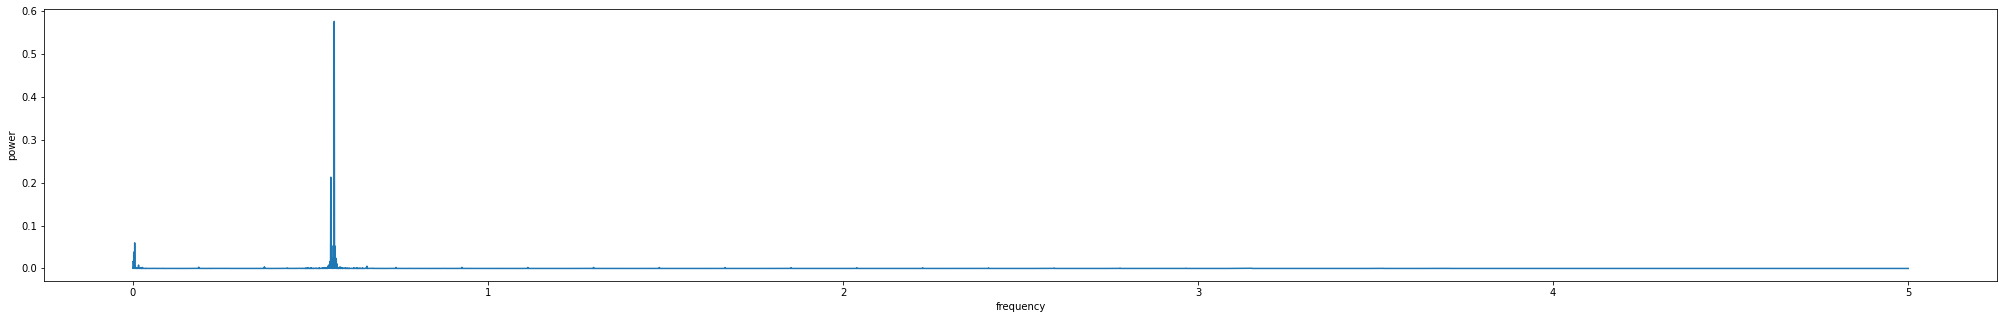

In [8]:
frequencies, power = plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

In [9]:
N_part=6000

In [10]:
X_part=X[:N_part]
Y_part=Y[:N_part]

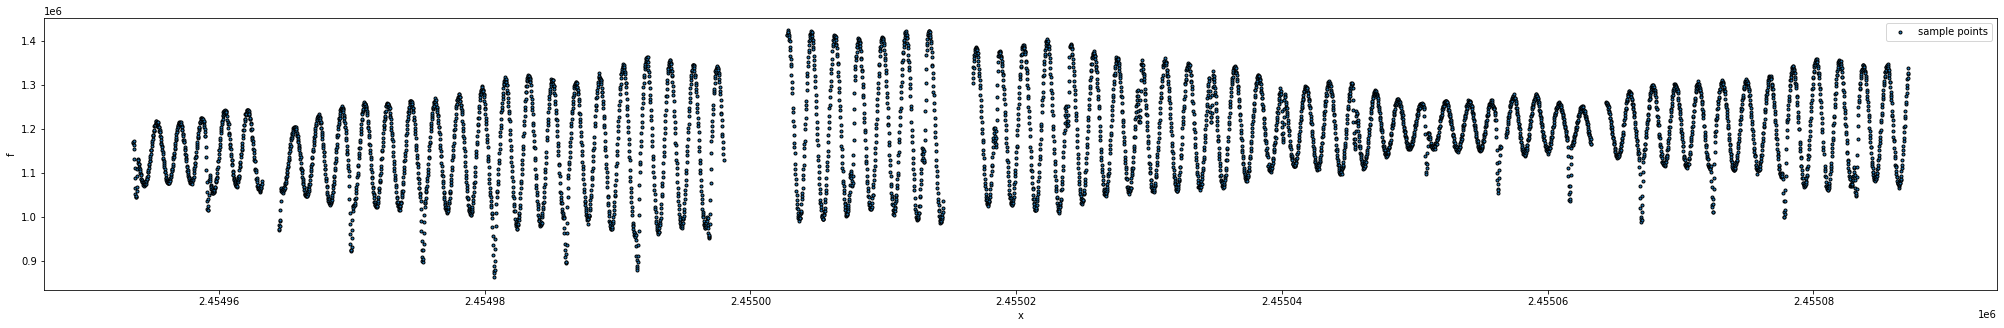

In [11]:
plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [12]:
def plot_kernel_samples(model, x, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    for i in range(nr_of_samples):
        Y_sample = model(x).sample()
        N = Y_sample.shape[0]
        plt.plot(range(N), Y_sample)

def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        if not var is None:
            plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    
def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [13]:
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)

In [14]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [15]:
def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

X_part_window = X_part.clone().detach()
print(X_part[:10])
X_part_window = torch.cat((X_part_window[:0], X_part_window[1000:]))
print(X_part[:10])

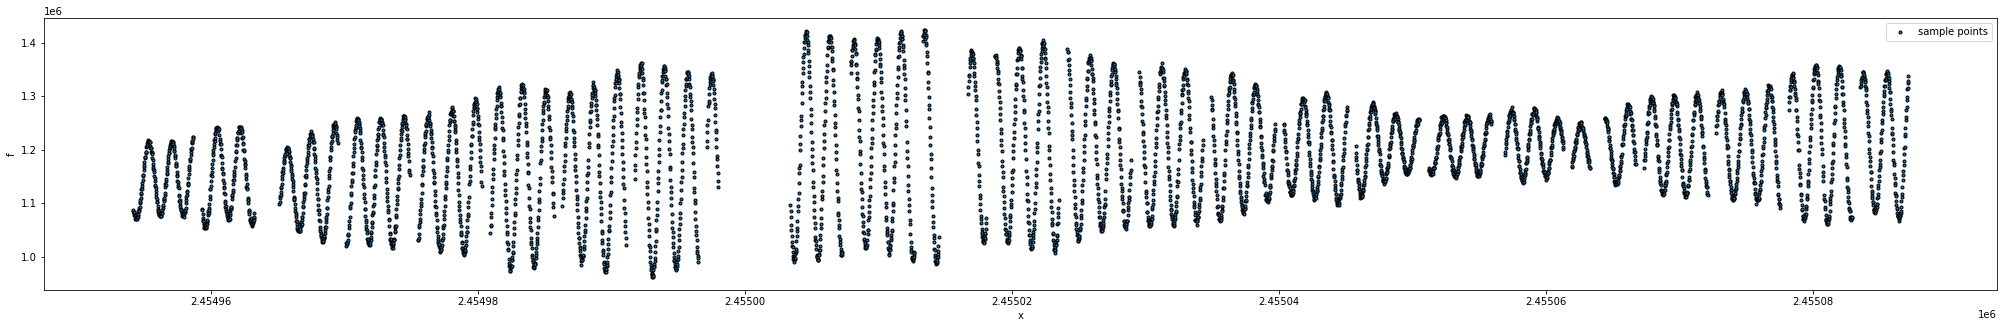

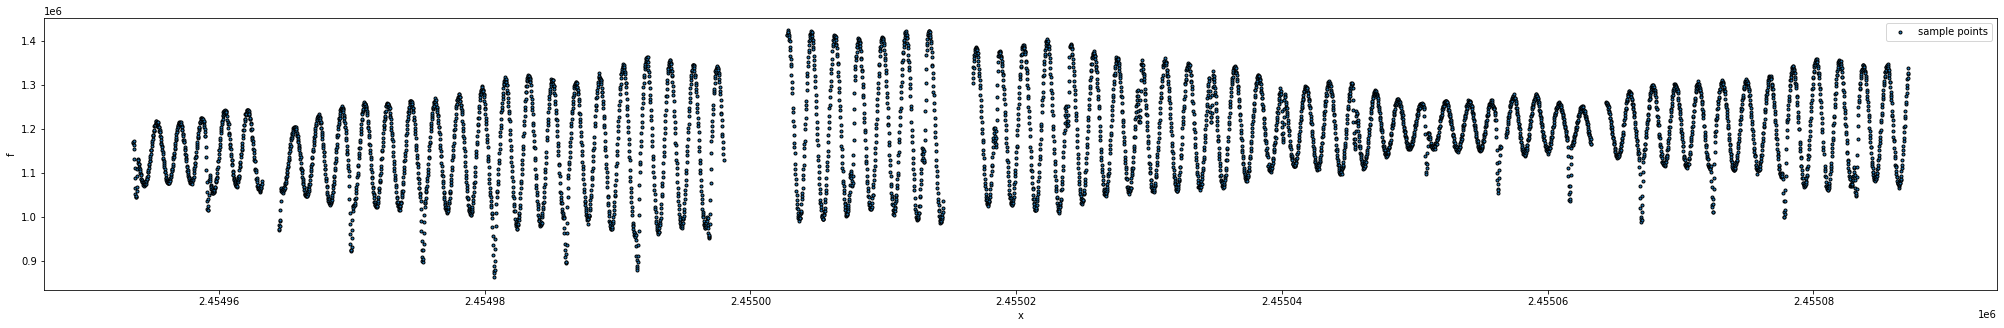

In [16]:
#eclipse_x = -4
#first_eclipse_date = X_part[eclipse_x]
first_eclipse_date = 2454953.28
window_size = 30  # todo: window size in dates?
period=5.402838838247893
X_part_window = X_part.clone().detach()
Y_part_window = Y_part.clone().detach()

# Find the next eclipse. Loop over dates here, as the positions in the array will change when we start deleting windows
next_eclipse_date = first_eclipse_date

while next_eclipse_date < X_part.max():
    next_eclipse_x = find_nearest_idx(X_part_window, next_eclipse_date).item()
    # Now delete the window
#    i = { "left" : max(int(next_eclipse_x-window_size/2), 0), "right": int(next_eclipse_x+window_size/2)}
    i = { "left" : max(int(next_eclipse_x), 0), "right": max(int(next_eclipse_x+window_size), 0)}
    X_part_window = torch.cat((X_part_window[:i['left']], X_part_window[i['right']:]))
    Y_part_window = torch.cat((Y_part_window[:i['left']], Y_part_window[i['right']:]))
    next_eclipse_date += period

plot_data(X_part_window, Y_part_window)
plot_data(X_part, Y_part)


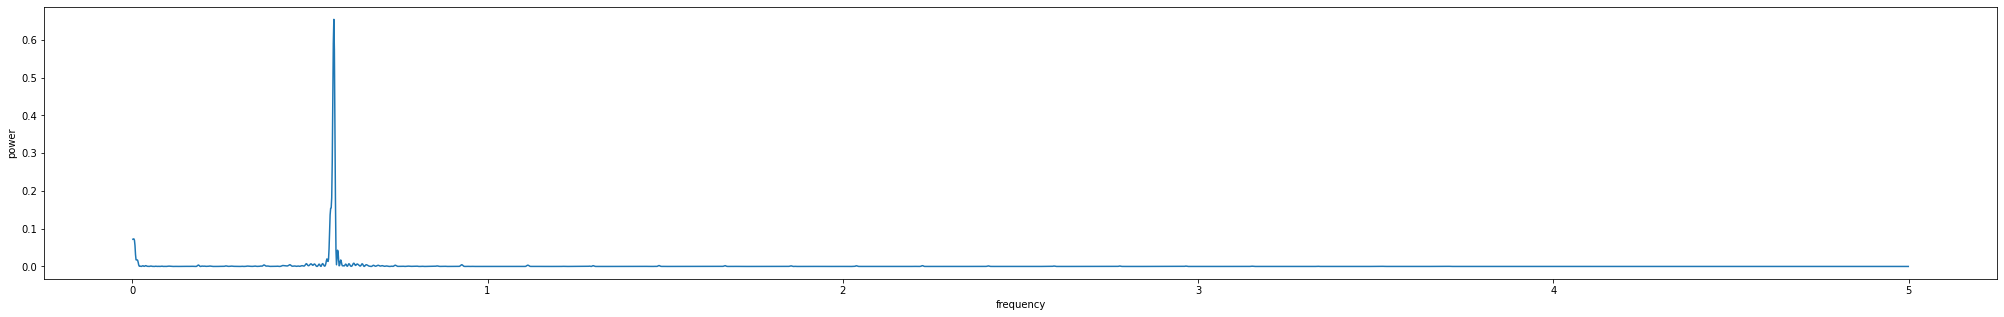

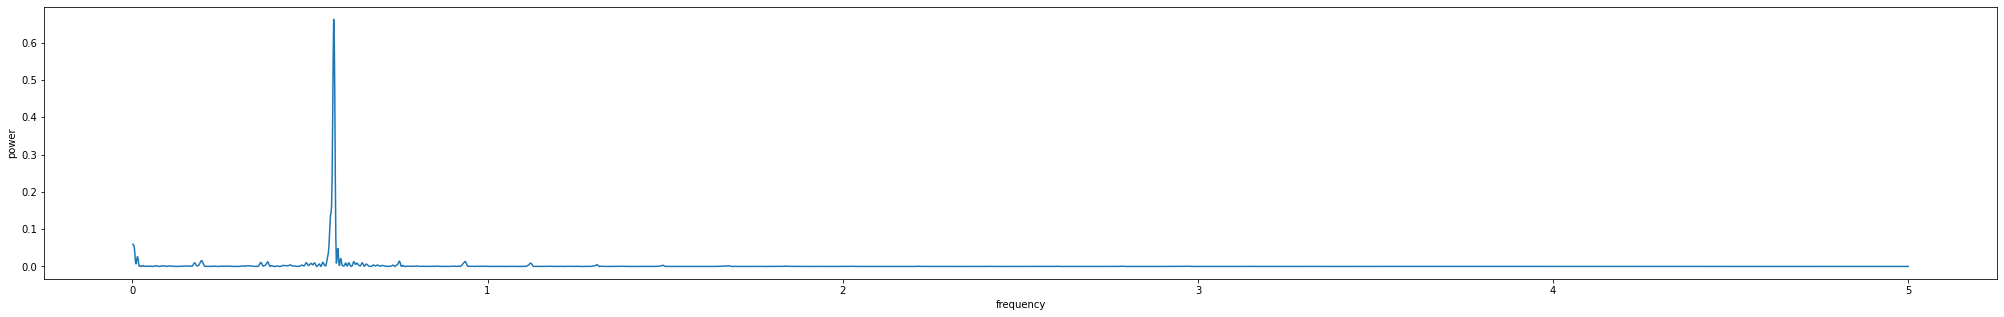

In [17]:
frequencies, power = plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)

In [18]:
def normalize(series):
   mean, std = series.mean(),series.std()
   series = (series - mean) / std
   return mean, std, series

In [19]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal has a major impact on the mean
# In other words, if we normalize first, then remove the E.B., the remaining signal will be somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
# normalize labels
mean, std = Y_part_window.mean(),Y_part_window.std()
mean, std, Y_part_window = normalize(Y_part_window)
_, _, Y_part = normalize(Y_part)

Move data and models to the GPU

In [20]:
if USE_CUDA:
    X_part_window = X_part_window.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part_window = Y_part_window.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [21]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # RBF kernel for the uncorrelated noise
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module.base_kernel.lengthscale=0.01

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part_window, Y_part_window, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

In [22]:
training_iter = 60

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
optimizer = torch.optim.Adam(all_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part_window)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part_window)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   Lengthscale: %.3f    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale,
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/60 - Loss: 1.401   Lengthscale: 0.010    noise: 0.693
Iter 2/60 - Loss: 1.354   Lengthscale: 0.012    noise: 0.621
Iter 3/60 - Loss: 1.298   Lengthscale: 0.013    noise: 0.554
Iter 4/60 - Loss: 1.239   Lengthscale: 0.016    noise: 0.493
Iter 5/60 - Loss: 1.171   Lengthscale: 0.018    noise: 0.437
Iter 6/60 - Loss: 1.102   Lengthscale: 0.021    noise: 0.386
Iter 7/60 - Loss: 1.012   Lengthscale: 0.024    noise: 0.340
Iter 8/60 - Loss: 0.929   Lengthscale: 0.028    noise: 0.298
Iter 9/60 - Loss: 0.831   Lengthscale: 0.033    noise: 0.261
Iter 10/60 - Loss: 0.738   Lengthscale: 0.039    noise: 0.228
Iter 11/60 - Loss: 0.636   Lengthscale: 0.045    noise: 0.198
Iter 12/60 - Loss: 0.544   Lengthscale: 0.052    noise: 0.171
Iter 13/60 - Loss: 0.438   Lengthscale: 0.060    noise: 0.148
Iter 14/60 - Loss: 0.336   Lengthscale: 0.070    noise: 0.127
Iter 15/60 - Loss: 0.235   Lengthscale: 0.081    noise: 0.109
Iter 16/60 - Loss: 0.136   Lengthscale: 0.094    noise: 0.094
Iter 17/60 - Loss

In [23]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along train_x
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_part_smooth))

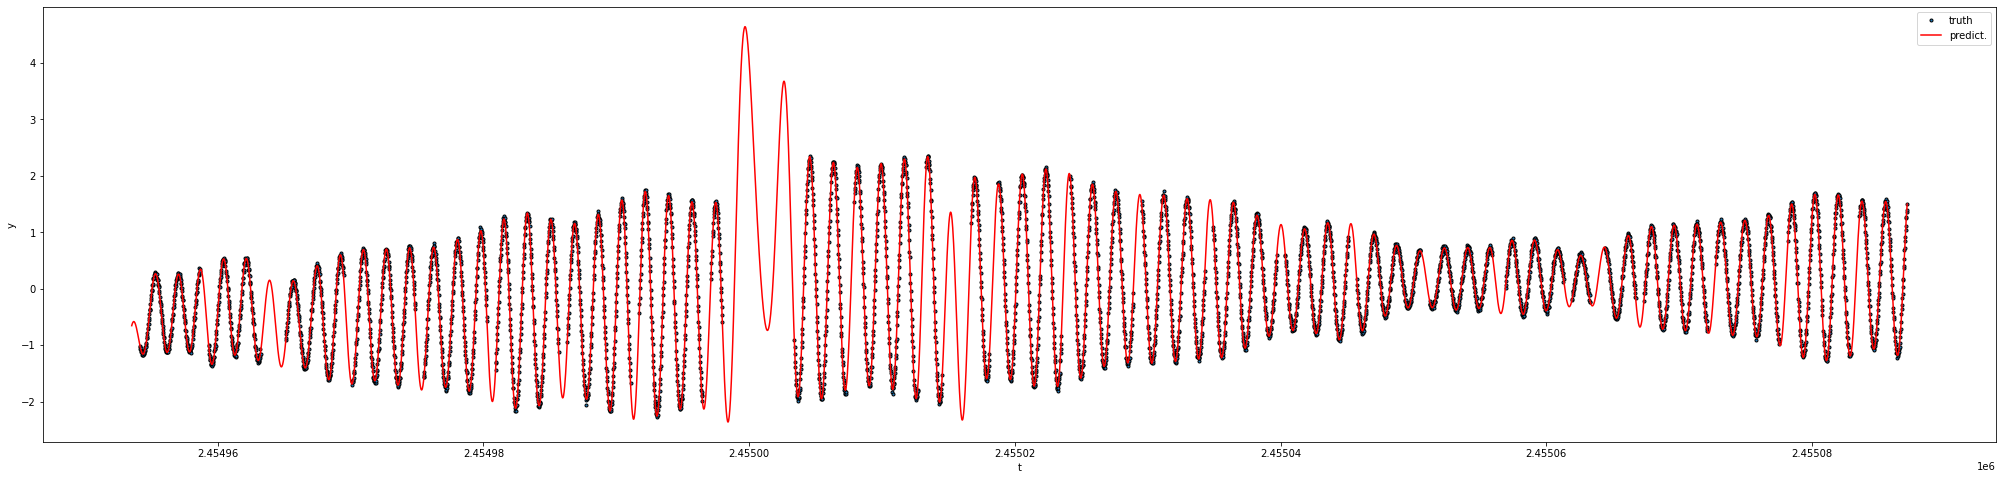

In [24]:
# Plot series with the smoothed X positions
with torch.no_grad():
    plot_series(X_part_window.cpu().numpy(), Y_part_window.cpu().numpy(), X_part_smooth.cpu().numpy(), observed_pred.mean.cpu().numpy())

In [25]:
Y_part.cpu().numpy()

array([-0.13502209, -0.11215942, -0.09061136, ...,  1.36601529,
        1.40332331,  1.5020235 ])

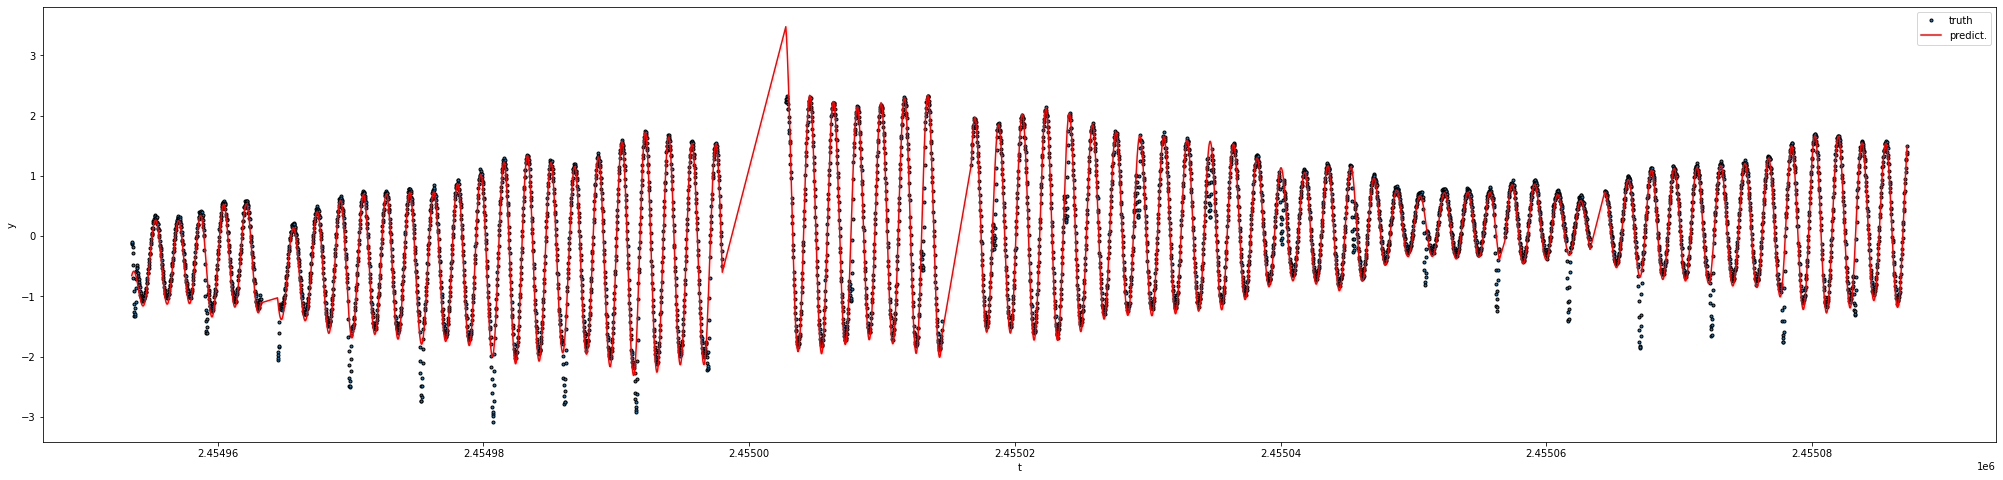

In [26]:
# Predict on the original X positions!
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_part_pred = likelihood(model(X_part))
    plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part.cpu().numpy(), Y_part_pred.mean.cpu().numpy())

In [27]:
Y_part_pred.mean.cpu()

tensor([-0.6548, -0.6365, -0.6209,  ...,  1.3650,  1.4348,  1.4985],
       dtype=torch.float64)

In [28]:
print(model.covar_module.base_kernel.lengthscale)

tensor([[0.9367]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)


# Correlation between the pulsation+noise data and the full data with E.B. removed

In [29]:
df = pd.read_csv("../data/sim_noisy_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
X_orig_pulse, Y_orig_pulse = df['Time'].tolist(), df['Lc'].tolist()
X_orig_pulse, Y_orig_pulse = np.array(X_orig_pulse), np.array(Y_orig_pulse)
X_orig_pulse = X_orig_pulse[:N_part]
Y_orig_pulse = Y_orig_pulse[:N_part]

In [30]:
# normalize the data, using the same formula as for the full signal!
# mean, std = Y_orig_pulse.mean(),Y_orig_pulse.std()
_, _, Y_orig_pulse = normalize(Y_orig_pulse)

In [31]:
ts_orig = pd.DataFrame()
ts_orig['signal'] = Y_orig_pulse.tolist()
ts_fitted = pd.DataFrame()
ts_fitted['signal'] = Y_part_pred.mean.cpu().numpy()

In [32]:
ts_orig.corrwith(ts_fitted)

signal   0.9986010760528296
dtype: float64

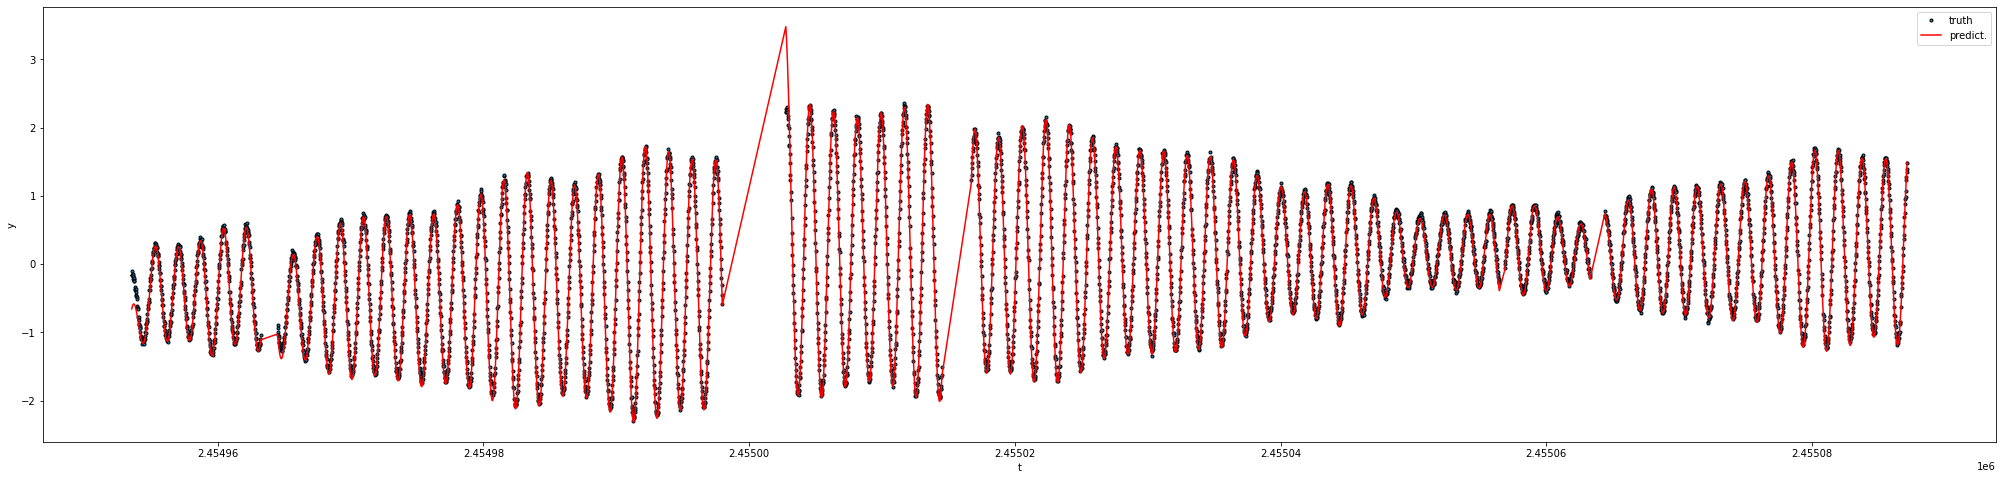

In [33]:
plot_series(X_orig_pulse, Y_orig_pulse, X_part.cpu().numpy(), Y_part_pred.mean.cpu().numpy())